# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
import os.path as osp
import sys

sys.path.insert(0, '../src')

import math

from easydict import EasyDict as edict
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms as T
from torchvision.transforms import functional as TF

import pytorch_lightning as pl
from torchsummaryX import summary

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

from config import __C, _to_values_only
from data import CLEVRMidrepsDataset
from backbones import RNEncoder, RNDecoder, RNDiscriminator
from discriminator import NLayerDiscriminator

from dotenv import load_dotenv
load_dotenv('../.env')

True

In [23]:
print(NLayerDiscriminator(3, out_pool=False, n_layers=5, stride=2))
NLayerDiscriminator(3, out_pool=False, n_layers=5, stride=2)(torch.randn(1, 3, 224, 224)).size()

NLayerDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momen

torch.Size([1, 1, 1, 1])

In [41]:
print(RNDiscriminator(512))
print(RNDiscriminator(512)(torch.randn(1, 3, 224, 224)).size())
print(count_parameters(RNDiscriminator(512)))

RNDiscriminator(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [50]:
count_parameters(RNEncoder(512)), count_parameters(RNDecoder(512, 256)), count_parameters(RNDiscriminator(4, 512))

[autoreload of config failed: Traceback (most recent call last):
  File "/home/samenabar/.venvs/grievous/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/samenabar/.venvs/grievous/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/samenabar/.venvs/grievous/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/samenabar/.venvs/grievous/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "../src/config.py", line 6, in <module>
    del __C.train.lr
AttributeError: lr
]


(1551936, 3839104, 3090400)

# Data

In [3]:
tasks = ["depths", "normals", "autoencoder"]

orig_dset = CLEVRMidrepsDataset(
    base_dir="/storage1/samenabar/code/CLMAC/clevr-dataset-gen/datasets/CLEVR_v1.2/",
    split="train",
    midreps=tasks,
    transform=CLEVRMidrepsDataset.std_img_transform,
    midreps_transform={
        "default": CLEVRMidrepsDataset.std_midreps_transforms,
        "shadeless": CLEVRMidrepsDataset.std_img_transform,
    },
)

orig_val_dset = CLEVRMidrepsDataset(
    base_dir="/storage1/samenabar/code/CLMAC/clevr-dataset-gen/datasets/CLEVR_v1.2/",
    split="val",
    midreps=tasks,
    transform=CLEVRMidrepsDataset.std_img_transform,
    midreps_transform={
        "default": CLEVRMidrepsDataset.std_midreps_transforms,
        "shadeless": CLEVRMidrepsDataset.std_img_transform,
    },
)

uni_dset = CLEVRMidrepsDataset(
    base_dir="/storage1/samenabar/code/CLMAC/clevr-dataset-gen/datasets/CLEVR_Uni_v1.2/",
    split="train",
    midreps=tasks,
    transform=CLEVRMidrepsDataset.std_img_transform,
    midreps_transform={
        "default": CLEVRMidrepsDataset.std_midreps_transforms,
        "shadeless": CLEVRMidrepsDataset.std_img_transform,
    },
)

uni_val_dset = CLEVRMidrepsDataset(
    base_dir="/storage1/samenabar/code/CLMAC/clevr-dataset-gen/datasets/CLEVR_Uni_v1.2/",
    split="val",
    midreps=tasks,
    transform=CLEVRMidrepsDataset.std_img_transform,
    midreps_transform={
        "default": CLEVRMidrepsDataset.std_midreps_transforms,
        "shadeless": CLEVRMidrepsDataset.std_img_transform,
    },
)

print('Orig train size:', len(orig_dset))
print('Orig val size:', len(orig_val_dset))
print('Uni train size:', len(uni_dset))
print('Uni val size:', len(uni_val_dset))

Orig train size: 70000
Orig val size: 3000
Uni train size: 70000
Uni val size: 3000


# PL Model

In [123]:
from PIL import Image

In [137]:
img, midreps = orig_dset[0]

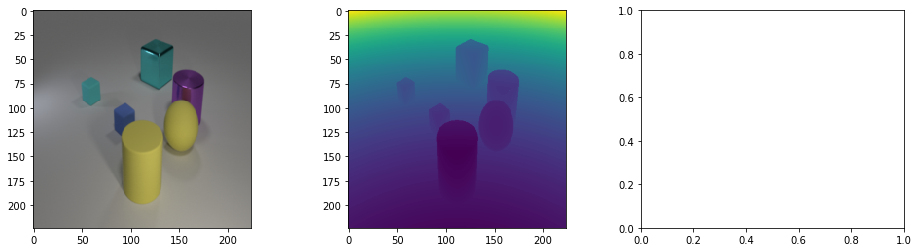

In [135]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
axes[0].imshow(TF.to_pil_image(img))
axes[1].imshow(midreps['depths'].squeeze(0))

In [4]:
def get_acc_at(lnorm_dist_map, val):
    acc = (lnorm_dist_map <= val).flatten(1).sum(1).float() / lnorm_dist_map.size(1)
    return acc

In [63]:
from collections import OrderedDict as odict
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from base_pl_model import BasePLModel
from utils import task_to_out_nc
from losses import bce_fill


class PLModel(BasePLModel):
    def __init__(self, cfg=None):
        super().__init__(cfg)

        self.many_validation = True
        self.encoder = RNEncoder(**cfg.model.encoder.kwargs)
        self.decoder = RNDecoder(tasks=cfg.tasks, **cfg.model.decoder.kwargs)

        if cfg.train.lnorm == "l1":
            self.lnorm = nn.L1Loss(reduction="none")
        elif cfg.train.lnorm == "l2":
            self.lnorm = nn.MSELoss(reduction="none")
        elif cfg.train.lnorm == "smooth_l1":
            self.lnorm = nn.SmoothL1Loss(reduction="none")
        else:
            print(f"Unkown lnorm: {cfg.train.lnorm}")

        intra_task_normalizer = cfg.train.lnorm_mult
        if cfg.model.discriminator.use:
            intra_task_normalizer += cfg.train.adv_mult
        self.lambdas = edict()
        self.lambdas.lnorm = cfg.train.lnorm_mult / intra_task_normalizer
        self.lambdas.adv = cfg.train.adv_mult / intra_task_normalizer

        inter_task_normalizar = sum(
            [cfg.train.task_lambdas[task] for task in cfg.tasks]
        )
        for task in cfg.tasks:
            self.lambdas[task] = cfg.train.task_lambdas[task] / inter_task_normalizar

        print("Multitask weights:")
        print(self.lambdas)

    def forward(self, img):
        features = self.encoder(img)
        midreps = self.decoder(features)
        return features, midreps

    def configure_optimizers(self):
        encoder_decoder_params = list(self.encoder.parameters())
        encoder_decoder_params += list(self.decoder.parameters())

        def make_opt(parameters, name):
            return torch.optim.Adam(
                parameters,
                lr=getattr(self.cfg.train.lrs, name, self.cfg.train.lrs.default),
                weight_decay=getattr(
                    self.cfg.train.weight_decay,
                    name,
                    self.cfg.train.weight_decay.default,
                ),
            )

        encoder_decoder_opt = make_opt(encoder_decoder_params, "encoder_decoder")
        encoder_decoder_sch = torch.optim.lr_scheduler.MultiStepLR(
            encoder_decoder_opt, milestones=[5, 10], gamma=0.1,
        )
        # if self.discriminators:
        #     discriminator_opt = make_opt(
        #         self.discriminators.parameters(), "discriminator"
        #     )
        #     return [encoder_decoder_opt, discriminator_opt], [encoder_decoder_sch]

        return [encoder_decoder_opt], [encoder_decoder_sch]

    def prepare_data(self):
        self.orig_train_dataset = CLEVRMidrepsDataset(
            base_dir=self.cfg.orig_dir,
            split="train",
            midreps=self.cfg.tasks,
            transform=CLEVRMidrepsDataset.std_img_transform,
            midreps_transform=CLEVRMidrepsDataset.std_midreps_transforms,
        )

        self.orig_val_dataset = CLEVRMidrepsDataset(
            base_dir=self.cfg.orig_dir,
            split="val",
            midreps=self.cfg.tasks,
            transform=CLEVRMidrepsDataset.std_img_transform,
            midreps_transform=CLEVRMidrepsDataset.std_midreps_transforms,
        )

        self.uni_train_dataset = CLEVRMidrepsDataset(
            base_dir=self.cfg.uni_dir,
            split="train",
            midreps=self.cfg.tasks,
            transform=CLEVRMidrepsDataset.std_img_transform,
            midreps_transform=CLEVRMidrepsDataset.std_midreps_transforms,
        )

        self.uni_val_dataset = CLEVRMidrepsDataset(
            base_dir=self.cfg.uni_dir,
            split="val",
            midreps=self.cfg.tasks,
            transform=CLEVRMidrepsDataset.std_img_transform,
            midreps_transform=CLEVRMidrepsDataset.std_midreps_transforms,
        )

    def train_dataloader(self):
        return DataLoader(
            self.orig_train_dataset,
            shuffle=True,
            drop_last=True,
            batch_size=self.cfg.train.bsz,
            num_workers=self.cfg.num_workers,
            pin_memory=self.use_cuda,
        )

    def val_dataloader(self):
        orig_val_loader = DataLoader(
            self.orig_val_dataset,
            shuffle=False,
            drop_last=False,
            batch_size=self.cfg.train.val_bsz,
            num_workers=self.cfg.num_workers,
            pin_memory=self.use_cuda,
        )

        uni_val_loader = DataLoader(
            self.uni_val_dataset,
            shuffle=False,
            drop_last=False,
            batch_size=self.cfg.train.val_bsz,
            num_workers=self.cfg.num_workers,
            pin_memory=self.use_cuda,
        )

        return [orig_val_loader, uni_val_loader]

    def validation_step(self, batch, batch_nb, dataset_idx=None):
        tgt_img, tgt_midreps = batch
        if "autoencoder" in self.cfg.tasks:
            tgt_midreps["autoencoder"] = tgt_img
        _, pred_midreps = self(tgt_img)
        stats = {}
        if dataset_idx == 0:
            prefix = "orig_"
        elif dataset_idx == 1:
            prefix = "uni_"
        else:
            prefix = ""
        for task in self.cfg.tasks:
            lnorm = self.lnorm(pred_midreps[task], tgt_midreps[task]).flatten(1).sum(1)
            abs_dist = (pred_midreps[task] - tgt_midreps[task]).abs()
            abs_dist = abs_dist.mean(1).flatten(1)

            stats[f"{prefix}val_{task}_lnorm"] = lnorm
            acc_levels = [0.01, 0.025, 0.05]
            for acc_l in acc_levels:
                stats[f"{prefix}val_{task}_{acc_l}"] = get_acc_at(abs_dist, acc_l)

        if batch_nb == 0:
            num_samples = 32
            img1 = make_grid(tgt_img[:num_samples], nrow=1).permute(1, 2, 0).cpu()
            img2 = make_grid(tgt_midreps["depths"][:num_samples], nrow=1)[0].cpu()
            img3 = make_grid(pred_midreps["depths"][:num_samples], nrow=1)[0].cpu()

            fig, axes = plt.subplots(
                nrows=1,
                ncols=1 + 2 * len(pred_midreps),
                figsize=(6 * (1 + 2 * len(pred_midreps)), 6 * num_samples),
            )
            plt.axis('off')
            
            img_ax = axes[0]
            img = make_grid(tgt_img[:num_samples], nrow=1).permute(1, 2, 0).cpu()
            img_ax.imshow(img)
            img_ax.set_title("Input image", fontsize=30)
            plt.subplots_adjust(wspace=0.01)
            # img_ax.axis("off")
            
            for i, task_name in enumerate(pred_midreps.keys()):
                gt_ax = axes[i * 2 + 1]
                pred_ax = axes[i * 2 + 2]
                
                gt_img = make_grid(tgt_midreps[task_name][:num_samples], nrow=1).cpu()
                if gt_img.size(0) == 1:
                    gt_img = gt_img.squeeze(0)
                else:
                    gt_img = gt_img.permute(1, 2, 0)
                pred_img = make_grid(pred_midreps[task_name][:num_samples], nrow=1).cpu()
                if pred_img.size(0) == 1:
                    pred_img = pred_img.squeeze(0)
                else:
                    pred_img = pred_img.permute(1, 2, 0)
            
                gt_ax.imshow(gt_img, cmap="viridis")
                pred_ax.imshow(pred_img, cmap="viridis")

                gt_ax.set_title(f"Real {task_name}", fontsize=30)
                pred_ax.set_title(f"Predicted {task_name}", fontsize=30)
            
            self.log_figure(fig, f"{prefix}validation", self.global_step)

        return stats

    def validation_epoch_end(self, outputs):
        stats = {}
        outputs = outputs[0]
        for k in outputs[0].keys():
            stats[k] = torch.cat([o[k] for o in outputs]).mean()

        return {
#             "progress_bar": {
#                 "val_depths_lnorm": stats["val_depths_lnorm"],
#                 "val_depths_acc_0.1": stats["val_depths_acc_0.1"],
#             },
            "log": stats,
        }

    def training_step(self, batch, batch_nb, optimizer_idx=None):
        tgt_img, tgt_midreps = batch
        if "autoencoder" in self.cfg.tasks:
            tgt_midreps["autoencoder"] = tgt_img
        if (optimizer_idx == 0) or (optimizer_idx is None):
            # Train encoder decoder
            
            _, pred_midreps = self(tgt_img)
            losses = {}
            stats = {}
            for task in self.cfg.tasks:
                lnorm_loss = self.lnorm(pred_midreps[task], tgt_midreps[task])
                lnorm_loss = lnorm_loss.flatten(1).sum(1).mean() * self.lambdas.lnorm
                abs_dist = (pred_midreps[task] - tgt_midreps[task]).abs()
                abs_dist = abs_dist.mean(1).flatten(1)
                losses[task] = {
                    "loss": lnorm_loss,
                    "lnorm": lnorm_loss,
                }
                acc_levels = [0.01, 0.025, 0.05]
                stats[task] = {
                    f"acc_{acc_l}": get_acc_at(abs_dist, acc_l).mean() for acc_l in acc_levels
                }

            total_loss = 0.0
            for task, loss in losses.items():
                total_loss += loss["loss"] * self.lambdas[task]

            tqdm_dict = {}
            for task, loss in losses.items():
                for lname, lval in loss.items():
                    if lname != "loss":
                        tqdm_dict[f"{task}_{lname}"] = lval
                tqdm_dict[f"{task}_acc_0.01"] = stats[task]["acc_0.01"]

            log = {**tqdm_dict}
            for task, _stats in stats.items():
                for sname, _stat in _stats.items():
                    log[f"{task}_{sname}"] = _stat

            if optimizer_idx == 0:
                self.stored_fake_batch = edict(
                    **{name: mr.detach() for name, mr in pred_midreps.items()}
                )

        elif optimizer_idx == 1:
            pred_midreps = self.stored_fake_batch
            losses = {}
            for task_name, disc in self.discriminators._modules.items():
                real_inp = torch.cat([tgt_img, tgt_midreps[task_name]], 1)
                real_inp += torch.empty_like(real_inp).normal_(0, 0.01)
                real2real = disc(real_inp)

                fake_inp = torch.cat([tgt_img, pred_midreps[task_name]], 1)
                fake_inp += torch.empty_like(fake_inp).normal_(0, 0.01)
                fake2real = disc(fake_inp)

                disc_loss = (
                    bce_fill(real2real, 1).mean() + bce_fill(fake2real, 0).mean()
                )
                disc_loss = disc_loss * 0.5 * self.lambdas.adv
                losses[task_name] = disc_loss

            total_loss = 0.0
            for task, loss in losses.items():
                total_loss += loss * self.lambdas[task]

            tqdm_dict = {}
            for task, loss in losses.items():
                tqdm_dict[f"{task}_d"] = loss

            log = tqdm_dict

        return {
            "loss": total_loss,
            "progress_bar": tqdm_dict,
            "log": log,
        }

# Config

In [42]:
from config import __C

cfg = _to_values_only(__C, 0)

cfg.logcomet = True
cfg.num_workers = 4
cfg.gpus = 1
cfg.train.lrs.default = 1e-4
cfg.train.bsz = 64
cfg.tasks = ["depths", "normals", "autoencoder"]

cfg.model.encoder = edict(kwargs=edict(out_nc=128))
cfg.model.decoder = edict(kwargs=edict(in_nc=cfg.model.encoder.kwargs.out_nc, last_nc=64))

cfg

{'cfg_file': None,
 'gpus': 1,
 'num_workers': 4,
 'random_seed': None,
 'logcomet': True,
 'comet_workspace': 'debug',
 'comet_project_name': 'debug',
 'run_name': '',
 'exp_name': '',
 'eval': False,
 'test': False,
 'checkpoint_path': None,
 'train': {'bsz': 64,
  'epochs': 15,
  'lr': 0.0001,
  'val_bsz': 64,
  'lrs': {'default': 0.0001, 'discriminator': 1e-05},
  'lnorm': 'smooth_l1',
  'weight_decay': {'default': 2e-06, 'discriminator': 1.9999999999999998e-05},
  'lnorm_mult': 0.996,
  'adv_mult': 0.004,
  'task_lambdas': {'depths': 1, 'normals': 1, 'autoencoder': 1},
  'adv_skip': True},
 'tasks': ['depths', 'normals', 'autoencoder'],
 'orig_dir': '/storage1/samenabar/code/CLMAC/clevr-dataset-gen/datasets/CLEVR_v1.2',
 'uni_dir': '/storage1/samenabar/code/CLMAC/clevr-dataset-gen/datasets/CLEVR_Uni_v1.2',
 'model': {'arch': 'rn',
  'backbone': {'kwargs': {'lightweight': True, 'layers': None}},
  'midreps': {'use': True, 'kwargs': {'normalize_outputs': True}},
  'decoder': {'kwarg

# Trainer

In [49]:
feats, midreps = model(torch.randn(4, 3, 224, 224).cuda())

In [57]:
midreps

{'depths': tensor([[[[0.0000e+00, 3.4779e-04, 5.1363e-06,  ..., 1.3569e-04,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            4.4637e-04, 0.0000e+00],
           [9.3857e-05, 0.0000e+00, 0.0000e+00,  ..., 1.2503e-04,
            0.0000e+00, 5.2949e-05],
           ...,
           [0.0000e+00, 0.0000e+00, 3.7088e-04,  ..., 0.0000e+00,
            2.7725e-04, 6.0293e-05],
           [3.2133e-06, 4.3519e-05, 8.0494e-05,  ..., 0.0000e+00,
            0.0000e+00, 7.1114e-05],
           [0.0000e+00, 8.4048e-05, 1.2755e-04,  ..., 0.0000e+00,
            1.0134e-04, 0.0000e+00]]],
 
 
         [[[1.2686e-05, 3.7355e-05, 1.9652e-04,  ..., 3.4362e-04,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            2.1628e-04, 0.0000e+00],
           [1.6220e-05, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 4.1101e-05],
           ...,
           [0.0000e+00, 0

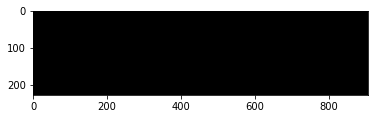

In [60]:
plt.imshow(make_grid(midreps['autoencoder']).cpu().permute(1, 2, 0))

In [ ]:
cfg.train.lrs.default = 1e-4

model = PLModel(cfg)
trainer = pl.Trainer(
    gpus=cfg.gpus,
    logger=model.make_comet_logger(),
    # callbacks=[progress_bar],
    max_epochs=cfg.train.epochs,
    # default_root_dir=model.exp_dir,
    checkpoint_callback=None,
    num_sanity_val_steps=1,
)

trainer.fit(model)

INFO:lightning:CometLogger will be initialized in online mode
INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


Multitask weights:
{'lnorm': 1.0, 'adv': 0.004016064257028113, 'depths': 0.3333333333333333, 'normals': 0.3333333333333333, 'autoencoder': 0.3333333333333333}


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/debug/debug/b1e74a0fd6a14c77bfcd67191d84854a
COMET INFO:   Parameters:
COMET INFO:     cfg_file                               : None
COMET INFO:     checkpoint_path                        : None
COMET INFO:     comet_project_name                     : debug
COMET INFO:     comet_workspace                        : debug
COMET INFO:     eval                                   : 1
COMET INFO:     exp_name                               : 1
COMET INFO:     gpus                                   : 1
COMET INFO:     logcomet                               : True
COMET INFO:     model/arch                             : rn
COMET INFO:     model/backbone/kwargs/layers           : None
COMET INFO:     model/backbone/kwargs/lightweight      : True
COMET INFO:  

Sent src to comet
